# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:

- /datasets/geo_data_0.csv. Скачать датасет
- /datasets/geo_data_1.csv. Скачать датасет
- /datasets/geo_data_2.csv. Скачать датасет


- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

- Lля обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


Признаки для модели:
- f0;
- f1;
- f2.

Целевой признак:

- product.

## Загрузка и подготовка данных

Импортируем необходимые для работы библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
import scipy as sp
import scipy.stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy.random import RandomState
state = RandomState(12345)

Загрузим каждый регион в свой датафрейм и получим информацию о каждом

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_0.info()
geo_data_0.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [3]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_1.info()
geo_data_1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [4]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_data_2.info()
geo_data_2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Во всех датафремах отсутствуют пропуски, но присутствуют нулевые значения в столбцах product. Посчитаем их количество

In [5]:
geo_data_0[geo_data_0['product'] == 0]

,id,f0,f1,f2,product
57263,zCM5W,-0.702064,0.375992,0.236572,0.0


In [6]:
geo_data_1[geo_data_1['product'] == 0]

,id,f0,f1,f2,product
11,OXyvW,16.320755,-0.562946,-0.001783,0.0
13,igmai,6.695604,-0.749449,-0.007630,0.0
62,Qjy5w,21.418478,-5.134490,-0.002836,0.0
63,G6WCj,6.822701,3.104979,-0.000723,0.0
77,MzQhL,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...,...
99936,YrRU8,5.085749,-3.980305,0.005063,0.0
99948,Jbnur,8.277805,-9.178818,0.003275,0.0
99956,aV1cJ,13.343983,-1.290200,0.005980,0.0
99961,Zjbn2,13.854163,-11.528089,-0.005556,0.0


In [7]:
geo_data_2[geo_data_2['product'] == 0]

,id,f0,f1,f2,product
68149,qeefd,-0.865596,-1.615247,-4.126441,0.0


В первом и третьем датасете всего по одному нулевому значению, а вот во втором  8235 из 100000.

Столбец id не пригодится нам, удалим его в каждом датасете

In [8]:
geo_data_0 = geo_data_0.drop(['id'],axis=1)
geo_data_1 = geo_data_1.drop(['id'],axis=1)
geo_data_2 = geo_data_2.drop(['id'],axis=1)

Чтобы визулизировать наши данные построим гистограммы 

<AxesSubplot:>

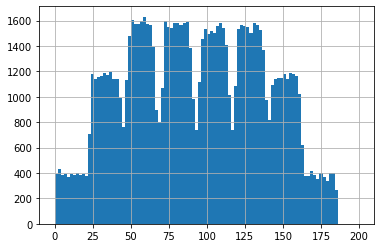

In [9]:
pd.Series(geo_data_0['product']).hist(range=(0, 200),bins=100)

<AxesSubplot:>

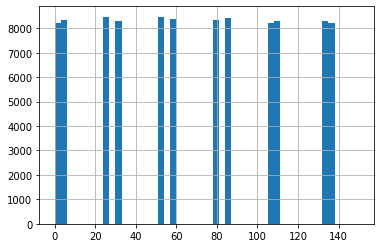

In [10]:
pd.Series(geo_data_1['product']).hist(range=(0, 150),bins=50)

<AxesSubplot:>

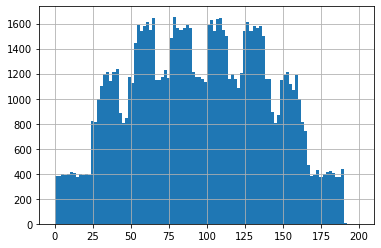

In [11]:
pd.Series(geo_data_2['product']).hist(range=(0, 200),bins=100)

# Вывод

В первом и третьем датасете по одному нулевому значению наблюдается, тогда как во втором 8.235%

## Обучение и проверка модели

Для группировки данных по трем датасетам в единую таблицу создадим листы для хранения результатов прогнозирования и их метрик. Проверим модель на всех трех датасетах с помощью цикла и сохраним результаты прогнозирований и метрик в наши листы

In [12]:
rmse_list = []
predictions_list = []
score_list = []
target_list = []
predictions_data = pd.DataFrame()
target_data = pd.DataFrame()

for i,j in zip([geo_data_0, geo_data_1, geo_data_2], range(3)):
    features = i.drop(['product'], axis=1)
    target = i['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    model = LinearRegression(n_jobs = -1)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions)**0.5
    rmse_list.append(rmse)
    predictions_list.append(predictions.mean())
    score_list.append(model.score(features_train, target_train))
    target_list.append(i['product'].mean())
    target_data[j] = target_valid
    predictions_data[j] = predictions

После цикла создадим таблицу по полученным данным

In [13]:
target_data = target_data.reset_index(drop=True)
scorelist = pd.DataFrame(
    data=[rmse_list, score_list, predictions_list, target_list],
    index=['RMSE', 'Score', 'Predicted mean', 'Target mean'],
    columns=['region 1', 'region 2', 'region 3'])
scorelist

,region 1,region 2,region 3
RMSE,37.579422,0.893099,40.029709
Score,0.274239,0.999625,0.196614
Predicted mean,92.592568,68.728547,94.965046
Target mean,92.500000,68.825000,95.000000


Рассматривая полученные данные по каждому региону можно сделать следующие выводы:

- средние спрогнозированные результаты почти идентичны с со средним значением target;
- модели первого и третьего регионов показывают плохой результат, не стоит бурить новую скважину в одном из этих регионов;
- модель региона под номером 2 показывает хороший результат. 

## Подготовка к расчёту прибыли

Условия задачи таковы:

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

На основании вышеизложенного посчитаем цену за бурение одной скважины и достаточный объем сырья для безубыточного бурения новой скважины

In [14]:
RESEARCH_POINTS = 500
BEST_POINTS = 200
BUDGET = 10000000000
ONE_BARREL_PROFIT = 450
ONE_PRODUCT_PROFIT = 450000
WELLBORING_PRICE = BUDGET/BEST_POINTS
WELLBORING_PRICE

50000000.0

In [15]:
PRODUCT_MIN = WELLBORING_PRICE/ONE_PRODUCT_PROFIT
PRODUCT_MIN

111.11111111111111

Для расчета прибыли по выбранным скважинам и предсказаниям модели напишем функцию

In [16]:
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return(450000*selected.sum() - (BUDGET))

Рассчитаем прибыль по каждому из трех регионов

In [17]:
print('Прибыль первого региона: {:.2f} млрд рублей'.format(profit(target_data[0], predictions_data[0], 200)/1000000000))
print('Прибыль второго региона: {:.2f} млрд рублей'.format(profit(target_data[1], predictions_data[1], 200)/1000000000))
print('Прибыль третьего региона: {:.2f} млрд рублей'.format(profit(target_data[2], predictions_data[2], 200)/1000000000))

Прибыль первого региона: 3.32 млрд рублей
Прибыль второго региона: 2.42 млрд рублей
Прибыль третьего региона: 2.71 млрд рублей


## Расчёт прибыли и рисков 

Используя метод bootstrap посчитаем прибыль для каждого региона

In [18]:
profits = []

for i in range(1000):
    target_subsample = target_data[0].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_data[0][target_subsample.index]
    profits.append(profit(target_subsample, probs_subsample, 200))
    
profits = pd.Series(profits)
lower = profits.quantile(0.025)
mean = profits.mean()
risks_1 = (profits < 0).mean()*100
print('Средняя прибыль:', mean/10000000000)
print('2,5% квантиль:', lower/10000000000)
print('Риск: {}'.format(risks_1))
final_profits = []
confidence_interval_1 = (profits.quantile(0.025), profits.quantile(0.975))
print('95% доверительный интервал:', confidence_interval_1)
final_profits.append(('region 1', mean/10000000000, lower/10000000000, confidence_interval_1, risks_1))

Средняя прибыль: 0.042593852691059246
2,5% квантиль: -0.010209009483793654
Риск: 6.0
95% доверительный интервал: (-102090094.83793654, 947976353.3583689)


In [19]:
profits = []

for i in range(1000):
    target_subsample = target_data[1].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_data[1][target_subsample.index]
    profits.append(profit(target_subsample, probs_subsample, 200))
    
profits = pd.Series(profits)
lower = profits.quantile(0.025)
mean = profits.mean()
risks_2 = (profits < 0).mean()*100
print('Средняя прибыль:', mean/10000000000)
print('2,5% квантиль:', lower/10000000000)
print('Риск: {:.2f}'.format(risks_2))
confidence_interval_2 = (profits.quantile(0.025), profits.quantile(0.975))
print('95% доверительный интервал:', confidence_interval_2)
final_profits.append(('region 2', mean/10000000000, lower/10000000000, confidence_interval_2, risks_2))

Средняя прибыль: 0.051825949369732484
2,5% квантиль: 0.012812323143308444
Риск: 0.30
95% доверительный интервал: (128123231.43308444, 953612982.0669085)


In [20]:
profits = []

for i in range(1000):
    target_subsample = target_data[2].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_data[2][target_subsample.index]
    profits.append(profit(target_subsample, probs_subsample, 200))
    
profits = pd.Series(profits)
lower = profits.quantile(0.025)
mean = profits.mean()
risks_3 = (profits < 0).mean()*100
print('Средняя прибыль:', mean/10000000000)
print('2,5% квантиль:', lower/10000000000)
print('Риск: {:.2f}'.format(risks_3))
confidence_interval_3 = (profits.quantile(0.025), profits.quantile(0.975))
print('95% доверительный интервал:', confidence_interval_3)
final_profits.append(('region 3', mean/10000000000, lower/10000000000, confidence_interval_3, risks_3))

Средняя прибыль: 0.04201940053440501
2,5% квантиль: -0.011585260916001143
Риск: 6.20
95% доверительный интервал: (-115852609.16001143, 989629939.8445739)


Для сравнения полученных данных сгруппируем полученные результаты в одну таблицу

In [21]:
result_data = pd.DataFrame(final_profits, columns=['Region', 'Mean Profit', 'Quantile 2.5%', 'Interval 95%', 'Risks %'])
cm = sns.light_palette("green", as_cmap=True)
result = result_data.style.background_gradient(cmap=cm)
result

,Region,Mean Profit,Quantile 2.5%,Interval 95%,Risks %
0,region 1,0.042594,-0.010209,"(-102090094.83793654, 947976353.3583689)",6.000000
1,region 2,0.051826,0.012812,"(128123231.43308444, 953612982.0669085)",0.300000
2,region 3,0.042019,-0.011585,"(-115852609.16001143, 989629939.8445739)",6.200000


Как мы видим из таблицы самые лучшие показатели у второго региона!

# Общий вывод

Для прогнозирования объема добываемого сырья нам было предоставлено 3 датасета по трем регионам. В первом и третьем датасете по одному нулевому значению наблюдается, тогда как во втором 8.235%. 
На основании полученных после обучения и проверки модели методом Логической регрессии данных по каждому региону можно сделать следующие выводы:

- средние спрогнозированные результаты почти идентичны с со средним значением target;
- модели первого и третьего регионов показывают плохой результат, не стоит бурить новую скважину в одном из этих регионов;
- модель региона под номером 2 показывает хороший результат. 

После расчетов прибили каждого региона следует вывод, что регион под номером 2 пригоден для использования в качестве региона для новой скважины!

По итогам расчета прибыли и рисков по каждому региону было выяснено, что самые лучшие показатели у второго региона. 